In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install libraries, download dataset, import libraries

In [ ]:
!pip -q install lightly
!pip -q install timm

In [ ]:
#CIFAR-10 dataset in ImageNet format (each class is a subfolder)
#https://github.com/knjcode/cifar2png
!pip install cifar2png

In [ ]:
!cifar2png cifar10 /content/cifar10png

In [6]:
path_to_train = "/content/cifar10png/train/"
path_to_test = "/content/cifar10png/test"

In [10]:
import copy
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from pytorch_lightning.loggers import TensorBoardLogger

from lightly.data import LightlyDataset
from lightly.loss import (
    BarlowTwinsLoss,
    DCLLoss,
    DCLWLoss,
    DINOLoss,
    NegativeCosineSimilarity,
    NTXentLoss,
    SwaVLoss,
    memory_bank,
)
from lightly.models import ResNetGenerator, modules, utils
from lightly.models.modules import heads
from lightly.transforms import SimCLRTransform
from lightly.transforms.utils import IMAGENET_NORMALIZE
from lightly.utils.benchmarking import BenchmarkModule

from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize



# Parameter defining and data preparation

In [8]:
max_epochs = 200
num_workers = 8
classes = 10

# Set to True to enable Distributed Data Parallel training.
distributed = False

# Set to True to enable Synchronized Batch Norm (requires distributed=True).
# If enabled the batch norm is calculated over all gpus, otherwise the batch
# norm is only calculated from samples on the same gpu.
sync_batchnorm = False

# Set to True to gather features from all gpus before calculating
# the loss (requires distributed=True).
# If enabled then the loss on every gpu is calculated with features from all gpus, otherwise only features from the same gpu are used.
gather_distributed = False

# benchmark
n_runs = 1  # optional, increase to create multiple runs and report mean + std
batch_size = 512
lr_factor = batch_size / 512  # scales the learning rate linearly with batch size

# Number of devices and hardware to use for training.
devices = torch.cuda.device_count() if torch.cuda.is_available() else 1
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

if distributed:
    strategy = "ddp"
    # reduce batch size for distributed training
    batch_size = batch_size // devices
else:
    strategy = "auto"  # Set to "auto" if using PyTorch Lightning >= 2.0 otherwise None
    # limit to single device if not using distributed training
    devices = min(devices, 1)


In [9]:
# Use SimCLR augmentations
simclr_transform = SimCLRTransform(
    input_size=32,
    cj_strength=0.5,
    gaussian_blur=0.0,
)


# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=IMAGENET_NORMALIZE["mean"],
            std=IMAGENET_NORMALIZE["std"],
        ),
    ]
)

# we use test transformations for getting the feature for kNN on train data
dataset_train_kNN = LightlyDataset(input_dir=path_to_train, transform=test_transforms)

dataset_test = LightlyDataset(input_dir=path_to_test, transform=test_transforms)


def create_dataset_train_ssl(model):
    """Helper method to apply the correct transform for ssl.

    Args:
        model:
            Model class for which to select the transform.
    """
    model_to_transform = {
        SimCLRModel: simclr_transform,
    }
    transform = model_to_transform[model]
    return LightlyDataset(input_dir=path_to_train, transform=transform)


def get_data_loaders(batch_size: int, dataset_train_ssl):
    """Helper method to create dataloaders for ssl, kNN train and kNN test.

    Args:
        batch_size: Desired batch size for all dataloaders.
    """
    dataloader_train_ssl = torch.utils.data.DataLoader(
        dataset_train_ssl,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers,
    )

    dataloader_train_kNN = torch.utils.data.DataLoader(
        dataset_train_kNN,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
    )

    dataloader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
    )

    return dataloader_train_ssl, dataloader_train_kNN, dataloader_test


# Model


In [11]:
class SimCLRModel(BenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes):
        super().__init__(dataloader_kNN, num_classes)
        # create a ResNet backbone and remove the classification head
        resnet = ResNetGenerator("resnet-18")
        self.backbone = nn.Sequential(
            *list(resnet.children())[:-1], nn.AdaptiveAvgPool2d(1)
        )
        self.projection_head = heads.SimCLRProjectionHead(512, 512, 128)
        self.criterion = NTXentLoss()


    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_index):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2 * lr_factor, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

In [12]:
# Create datasets and dataloaders
dataset_train_simclr = create_dataset_train_ssl(SimCLRModel)
dataloader_train_simclr, dataloader_train_kNN, dataloader_test = get_data_loaders(
    batch_size=batch_size, dataset_train_ssl=dataset_train_simclr
)

model=SimCLRModel(dataloader_train_kNN,classes)

In [13]:
model

SimCLRModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2)

# Configure logdir, callbacks and trainer

In [14]:
from pytorch_lightning.callbacks import Callback

class FileUpload(Callback):
    def __init__(self,ckptdir, weightdir,uploaddir,filename = ""):
        self.ckptdir = ckptdir
        self.weightdir = weightdir
        self.uploaddir = uploaddir
        self.filename = filename

    def on_train_epoch_end(self,trainer, pl_module):
        epoch = trainer.current_epoch+1
        ckpt_name = self.filename + f"checkpoint-epoch={epoch:02d}.pth"
        ckpt_path = os.path.join(ckptdir,ckpt_name)
        trainer.save_checkpoint(ckpt_path)
        ckpt_upload_path = self.uploaddir+"/ckpts/"
        !gsutil -mq cp {ckpt_path} {ckpt_upload_path}


class PrintMetrics(Callback):
    def on_train_epoch_end(self,trainer, pl_module):
        epoch = trainer.current_epoch+1
        metrics = {}
        for key,val in trainer.logged_metrics.items():
            metrics[key] = np.float(val)
        print(f"Epoch-{epoch:02d}: {metrics}")

In [15]:
from pytorch_lightning.callbacks import (DeviceStatsMonitor, ModelCheckpoint,
                                         EarlyStopping, LearningRateMonitor,ModelSummary)
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning import Trainer
import os
from datetime import datetime
cal_date = datetime.today().strftime('%Y-%m-%d')
date = cal_date[-2:]
month =cal_date[-5:-3]
year = cal_date[:4]

logdir = "logs/"
ckptdir = "ckpt_dir/"
weightdir = "weights/"
dir_name = "Embed-resnet18_batch512"+f"-{date}_{month}_{year}"
uploaddir = f"gs:///{dir_name}"

os.makedirs(logdir, exist_ok = True)
os.makedirs(ckptdir, exist_ok = True)
os.makedirs(weightdir,exist_ok = True)

In [16]:
## callbacks
gpu_monitor_callback = DeviceStatsMonitor()
progressbar_callback = TQDMProgressBar(refresh_rate= 3)
lr_monitor_callback = LearningRateMonitor()

fileupload_callback = FileUpload(ckptdir,weightdir,uploaddir,"Embed-resnet18"+"-")

callbacks = [PrintMetrics(),lr_monitor_callback,progressbar_callback,fileupload_callback,ModelSummary()]

trainer = Trainer(
                  max_epochs = max_epochs,
                  num_sanity_val_steps=1,
                  precision = "16-mixed",
                  callbacks = callbacks,
                  accumulate_grad_batches=4,
                  accelerator='gpu',
                  devices=-1,
                  strategy=strategy,
                  sync_batchnorm=sync_batchnorm,
                  reload_dataloaders_every_n_epochs = True,
                  )

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model, dataloader_train_simclr)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
45.991    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-14-ebb6631607e8>:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics[key] = np.float(val)


Epoch-01: {'train_loss_ssl': 6.042652130126953}
Epoch-02: {'train_loss_ssl': 5.934974670410156}
Epoch-03: {'train_loss_ssl': 5.9409942626953125}
Epoch-04: {'train_loss_ssl': 5.871349334716797}
Epoch-05: {'train_loss_ssl': 5.8300018310546875}
Epoch-06: {'train_loss_ssl': 5.788887023925781}
Epoch-07: {'train_loss_ssl': 5.7585296630859375}
Epoch-08: {'train_loss_ssl': 5.736682891845703}
Epoch-09: {'train_loss_ssl': 5.756610870361328}
Epoch-10: {'train_loss_ssl': 5.690513610839844}
Epoch-11: {'train_loss_ssl': 5.6529388427734375}
Epoch-12: {'train_loss_ssl': 5.642658233642578}
Epoch-13: {'train_loss_ssl': 5.625679016113281}
Epoch-14: {'train_loss_ssl': 5.616863250732422}
Epoch-15: {'train_loss_ssl': 5.6295013427734375}
Epoch-16: {'train_loss_ssl': 5.6265106201171875}
Epoch-17: {'train_loss_ssl': 5.6057891845703125}
Epoch-18: {'train_loss_ssl': 5.598564147949219}
Epoch-19: {'train_loss_ssl': 5.588947296142578}
Epoch-20: {'train_loss_ssl': 5.619220733642578}
Epoch-21: {'train_loss_ssl': 5.58

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


# Generate embeddings

In [18]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, _, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

In [21]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=5, num_examples=10):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join("/content/cifar10png/test", filenames[neighbor_idx])

            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            # let's disable the axis
            plt.axis("off")

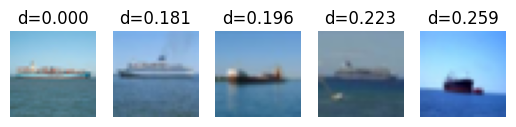

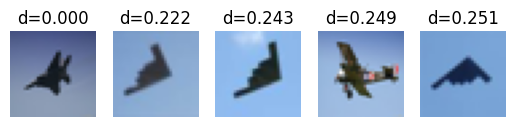

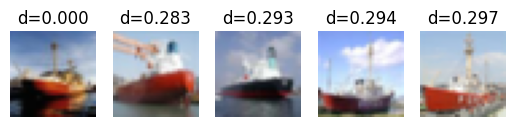

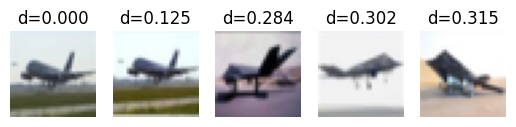

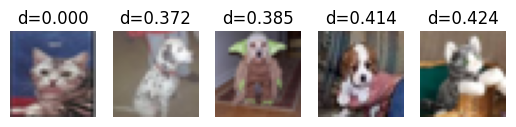

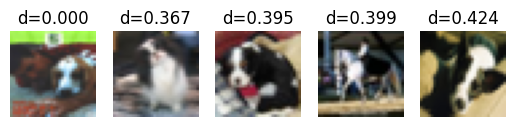

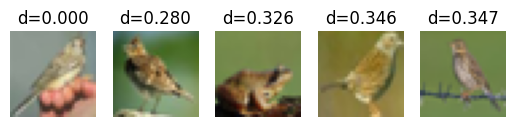

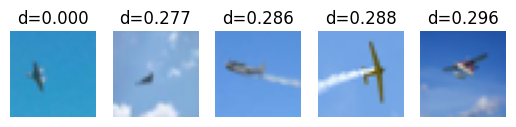

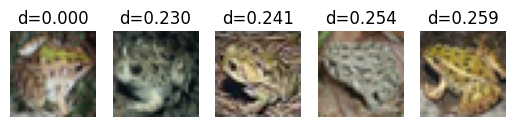

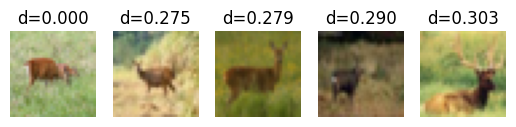

In [22]:
plot_knn_examples(embeddings, filenames)

In [23]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
import numpy as np

nbrs_2 = NearestNeighbors(n_neighbors=5, metric='euclidean').fit(embeddings)


# Perform kNN search
distances, indices = nbrs_2.kneighbors(embeddings)

# to get true labels
test_dir = "/content/cifar10png/test"

# Get all subfolders (class folders)
class_folders = sorted(os.listdir(test_dir))

# Dictionary mapping class names to labels
class_to_label = {class_name: i for i, class_name in enumerate(class_folders)}

true_labels = []
for class_name in class_folders:
    class_dir = os.path.join(test_dir, class_name)
    files = os.listdir(class_dir)
    true_labels.extend([class_to_label[class_name]] * len(files))

true_labels = np.array(true_labels)

# Evaluate correctness for each query embedding
predicted_labels = []
for i, neighbors in enumerate(indices):
    neighbor_labels = true_labels[neighbors[1:]]  # Exclude self

    mode_label = np.argmax(np.bincount(neighbor_labels))
    predicted_labels.append(mode_label)

predicted_labels = np.array(predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.76


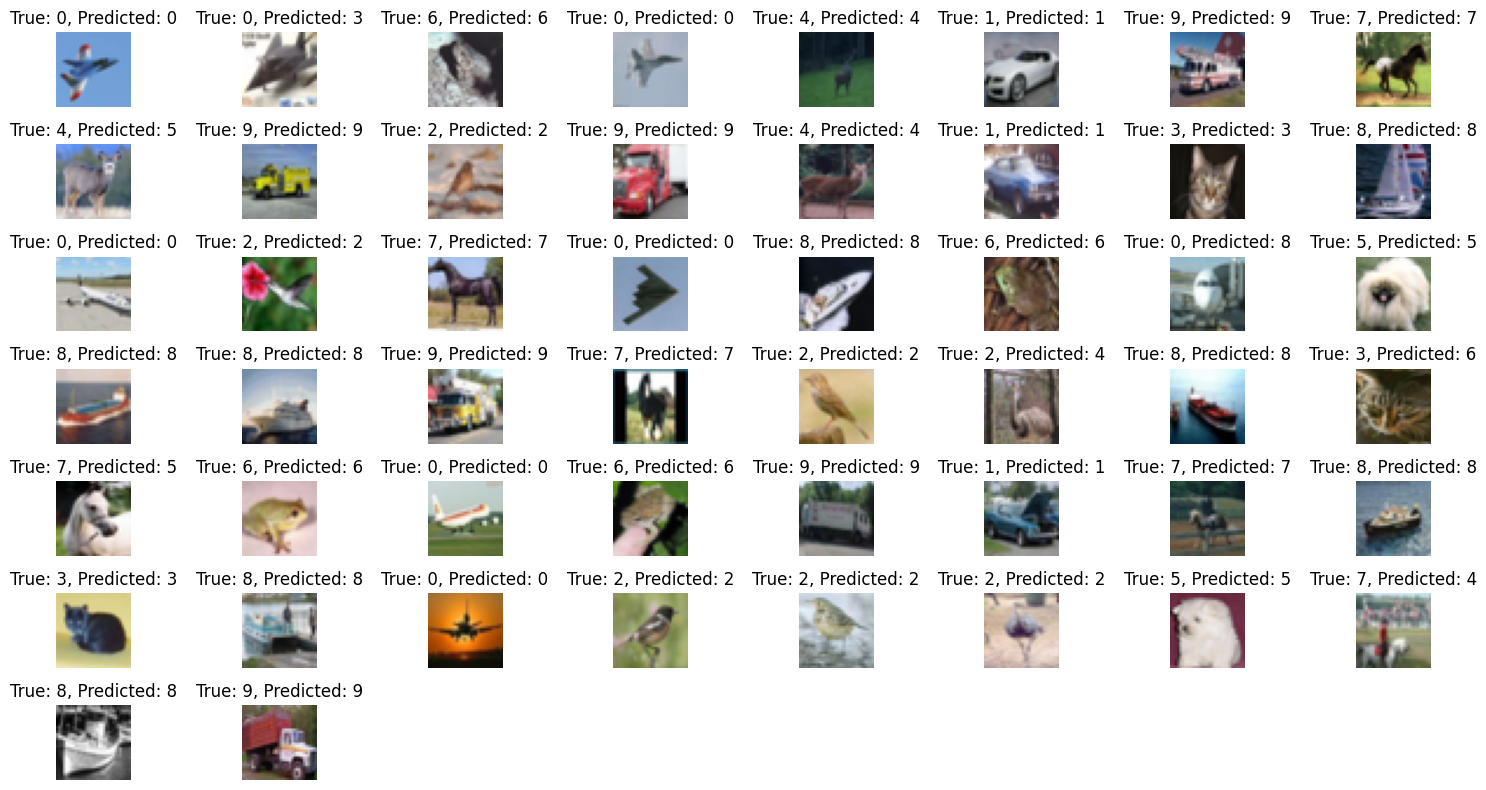

In [24]:
import random
from PIL import Image

# Choosing random examples to visualize
num_examples_to_visualize = 50
sample_indices = random.sample(range(len(true_labels)), num_examples_to_visualize)

# Visualize the examples
num_cols = 8
num_rows = num_examples_to_visualize // num_cols + (num_examples_to_visualize % num_cols > 0)
plt.figure(figsize=(15, 8))
for i, idx in enumerate(sample_indices, 1):
    plt.subplot(num_rows, num_cols, i)

    # Get the corresponding filename for the current index
    fname = os.path.join(test_dir, filenames[idx])

    # Load the image
    img = Image.open(fname)
    plt.imshow(img)
    plt.title(f"True: {true_labels[idx]}, Predicted: {predicted_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
